In [11]:
!pip install matplotlib

In [12]:
import chromadb
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import sys
import os
from dotenv import load_dotenv
import json
import random
import traceback

In [13]:
# --- ChromaDB Client Initialization ---
try:
    client = chromadb.PersistentClient(path="data/chroma_db")
    print("✅ ChromaDB client initialized successfully.")
except Exception as e:
    print(f"❌ Failed to initialize ChromaDB client: {e}")
    exit()

✅ ChromaDB client initialized successfully.


In [44]:
import numpy as np
import os
import json
import chromadb
import traceback

# Asumimos que 'client' ya está inicializado en una celda anterior.

def load_embeddings_to_chroma(file_path, collection_name, distance_metric='cosine', normalize_embeddings=False, description=""):
    """
    Carga, valida y (opcionalmente) normaliza embeddings antes de almacenarlos.
    Crea la colección con la métrica de distancia especificada.
    
    Args:
        file_path (str): Ruta al archivo JSON de embeddings.
        collection_name (str): Nombre para la colección de ChromaDB.
        distance_metric (str): 'cosine' o 'l2'.
        normalize_embeddings (bool): Si es True, normaliza los vectores antes de cargarlos.
        description (str): Descripción para la colección.
    """
    print("-" * 50)
    print(f"🚀 Iniciando proceso para '{collection_name}' (Métrica: {distance_metric.upper()})")

    try:
        client.delete_collection(name=collection_name)
        print(f"🗑️ Se eliminó la colección antigua '{collection_name}'.")
    except Exception:
        print(f"ℹ️ No se encontró la colección '{collection_name}', se creará una nueva.")

    if not os.path.exists(file_path):
        print(f"❌ ERROR: No se encontró el archivo {file_path}. Abortando.")
        return

    try:
        with open(file_path, 'r') as f:
            items = json.load(f).get('items', [])
        
        valid_records = []
        for item in items:
            if 'id' in item and 'metadata' in item and 'embedding' in item and item['embedding']:
                raw_embedding = item['embedding']
                final_embedding = raw_embedding[0] if isinstance(raw_embedding[0], list) else raw_embedding
                valid_records.append({'id': str(item['id']), 'embedding': final_embedding, 'metadata': item['metadata']})
        
        if not valid_records:
            print("❌ No se encontraron registros válidos. Abortando.")
            return

        print(f"✅ Se encontraron {len(valid_records)} registros válidos.")

        ids = [r['id'] for r in valid_records]
        metadatas = [r['metadata'] for r in valid_records]
        embeddings = [r['embedding'] for r in valid_records]
        documents = [r['metadata'].get('question', f"Item {r['id']}") for r in valid_records]

        # --- LÓGICA DE NORMALIZACIÓN CONDICIONAL ---
        if normalize_embeddings:
            print("🔄 Normalizando embeddings (requerido para OpenCLIP)...")
            normalized_list = []
            for emb in embeddings:
                emb_np = np.array(emb, dtype=np.float32)
                norm = np.linalg.norm(emb_np)
                normalized_list.append((emb_np / norm).tolist() if norm > 0 else emb_np.tolist())
            embeddings = normalized_list
            print("✅ Normalización completada.")
        else:
            print("✅ Omitiendo normalización manual (asumiendo embeddings pre-normalizados).")

        # Crear la colección
        collection_metadata = {}
        if distance_metric == 'cosine':
            collection_metadata["hnsw:space"] = "cosine"
            print("✅ Configurando colección para distancia COSENO.")
        else: # 'l2' es el valor por defecto
            print("✅ Configurando colección para distancia L2 (Euclidiana).")
        
        if description:
            collection_metadata["description"] = description

        collection = client.create_collection(name=collection_name, metadata=collection_metadata)

        # Añadir los datos
        batch_size = 100
        for i in range(0, len(ids), batch_size):
            collection.add(
                ids=ids[i:i+batch_size],
                embeddings=embeddings[i:i+batch_size],
                metadatas=metadatas[i:i+batch_size],
                documents=documents[i:i+batch_size]
            )
        
        print(f"🎉 Se cargaron exitosamente {collection.count()} embeddings en '{collection_name}'.")

    except Exception as e:
        print(f"❌ Ocurrió un error inesperado: {e}")
        traceback.print_exc()

# --- EJECUCIÓN DE LA CARGA DE TODAS LAS COLECCIONES ---

# Nombres de archivos de Cohere
cohere_validation_file = "data/embeddings/lf_vqa_validation_embeddings_cohere.json"
cohere_train_file = "data/embeddings/lf_vqa_db_embeddings_cohere.json"

# Nombres de archivos de OpenCLIP
openclip_validation_file = "data/embeddings/lf_vqa_validation_embeddings_openclip.json"
openclip_train_file = "data/embeddings/lf_vqa_db_embeddings_openclip.json"

# Nombres para las colecciones de Cohere
COHERE_VALIDATION_COSINE = "viswiz_validation_cohere_cosine"
COHERE_TRAIN_COSINE = "viswiz_train_cohere_cosine"
COHERE_VALIDATION_L2 = "viswiz_validation_cohere_l2"
COHERE_TRAIN_L2 = "viswiz_train_cohere_l2"

# Nombres para las colecciones de OpenCLIP
OPENCLIP_VALIDATION_COSINE = "viswiz_validation_openclip_cosine"
OPENCLIP_TRAIN_COSINE = "viswiz_train_openclip_cosine"

# 1. Cargar datos de Cohere para Coseno (sin normalización extra)
load_embeddings_to_chroma(cohere_validation_file, COHERE_VALIDATION_COSINE, 'cosine', normalize_embeddings=False, description="Cohere - Validation - Cosine")
load_embeddings_to_chroma(cohere_train_file, COHERE_TRAIN_COSINE, 'cosine', normalize_embeddings=False, description="Cohere - Train - Cosine")

# 2. Cargar datos de Cohere para L2 (sin normalización extra)
load_embeddings_to_chroma(cohere_validation_file, COHERE_VALIDATION_L2, 'l2', normalize_embeddings=False, description="Cohere - Validation - L2")
load_embeddings_to_chroma(cohere_train_file, COHERE_TRAIN_L2, 'l2', normalize_embeddings=False, description="Cohere - Train - L2")

# 3. Cargar datos de OpenCLIP para Coseno (CON normalización)
load_embeddings_to_chroma(openclip_validation_file, OPENCLIP_VALIDATION_COSINE, 'cosine', normalize_embeddings=True, description="OpenCLIP - Validation - Cosine")
load_embeddings_to_chroma(openclip_train_file, OPENCLIP_TRAIN_COSINE, 'cosine', normalize_embeddings=True, description="OpenCLIP - Train - Cosine")

print("\n\n✅✅✅ Proceso de carga de todas las colecciones finalizado. ✅✅✅")

--------------------------------------------------
🚀 Iniciando proceso para 'viswiz_validation_cohere_cosine' (Métrica: COSINE)
ℹ️ No se encontró la colección 'viswiz_validation_cohere_cosine', se creará una nueva.
✅ Se encontraron 100 registros válidos.
✅ Omitiendo normalización manual (asumiendo embeddings pre-normalizados).
✅ Configurando colección para distancia COSENO.
🎉 Se cargaron exitosamente 100 embeddings en 'viswiz_validation_cohere_cosine'.
--------------------------------------------------
🚀 Iniciando proceso para 'viswiz_train_cohere_cosine' (Métrica: COSINE)
ℹ️ No se encontró la colección 'viswiz_train_cohere_cosine', se creará una nueva.
✅ Se encontraron 500 registros válidos.
✅ Omitiendo normalización manual (asumiendo embeddings pre-normalizados).
✅ Configurando colección para distancia COSENO.
🎉 Se cargaron exitosamente 500 embeddings en 'viswiz_train_cohere_cosine'.
--------------------------------------------------
🚀 Iniciando proceso para 'viswiz_validation_cohere

✅ Nombres de las colecciones definidos para la búsqueda.
--------------------------------------------------
🚀 BÚSQUEDA con COHERE (L2 - DEFAULT) para el ID de validación: 113


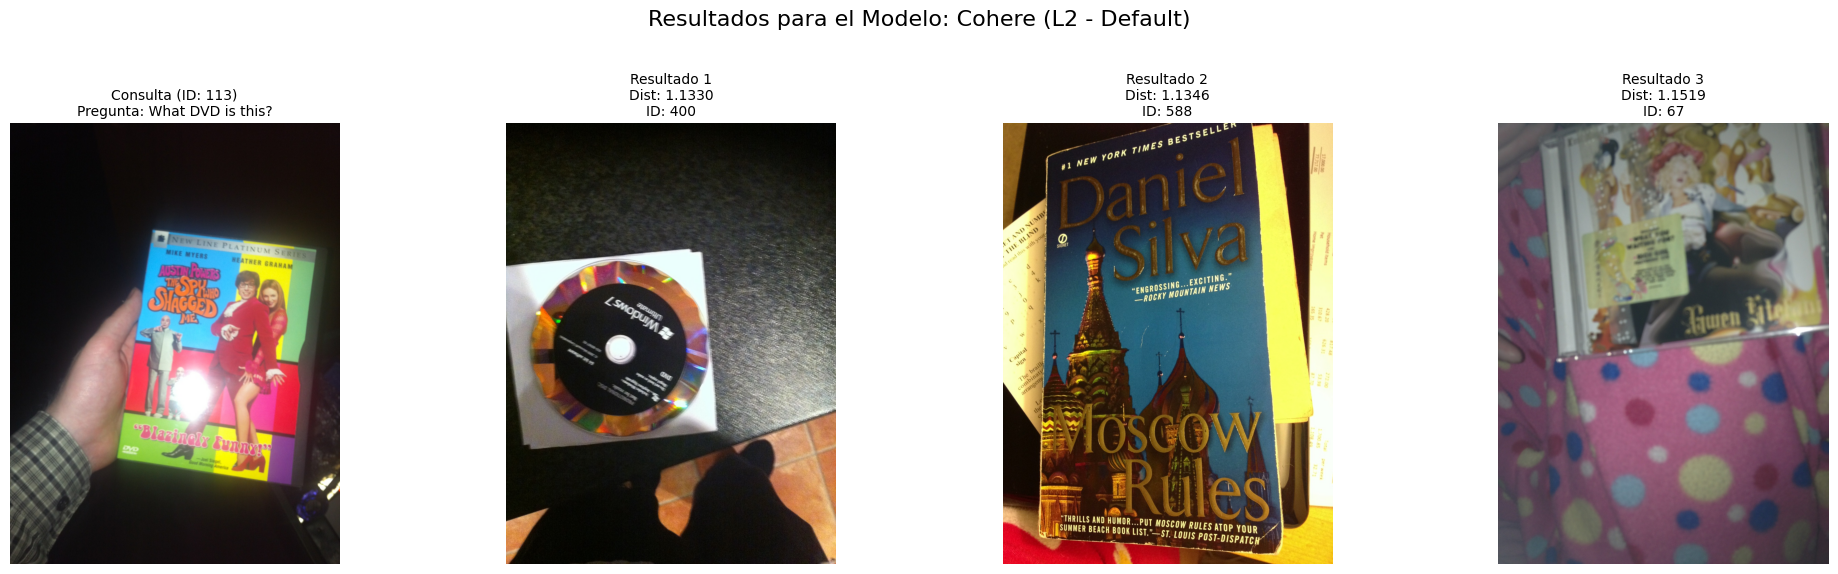

--------------------------------------------------
🚀 BÚSQUEDA con COHERE (COSENO) para el ID de validación: 113


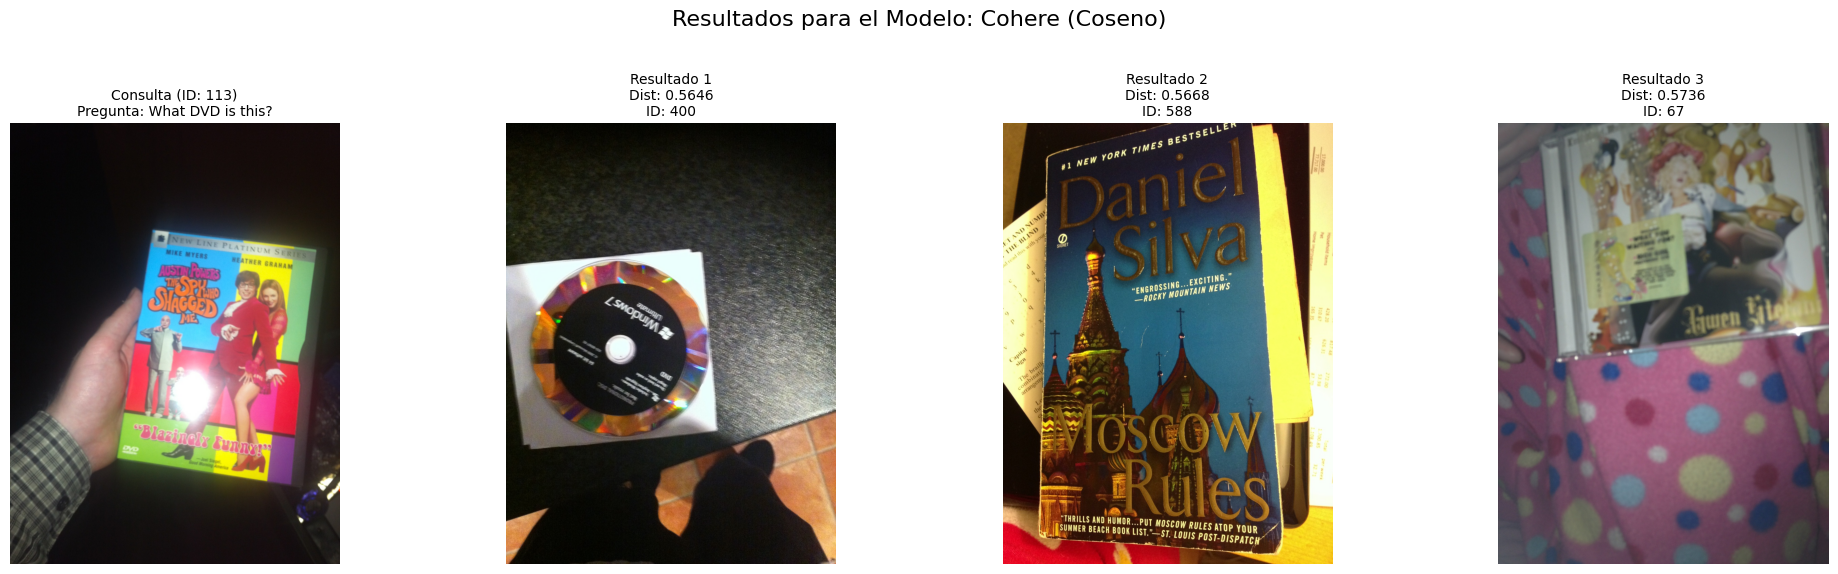

--------------------------------------------------
🚀 BÚSQUEDA con OPENCLIP (COSENO) para el ID de validación: 113


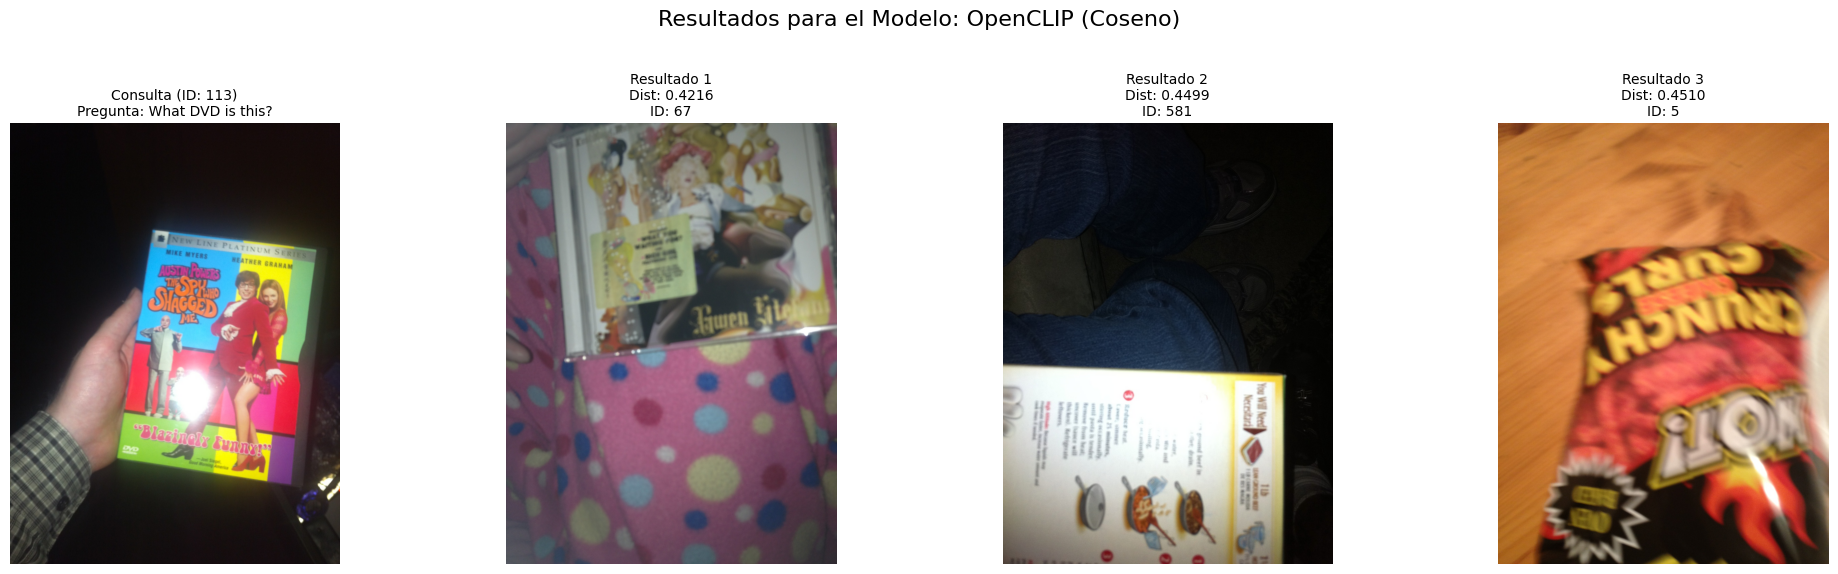

In [14]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

# --- Nombres de todas las colecciones que hemos creado ---
# (Deben coincidir exactamente con los de la celda de carga)
COHERE_VALIDATION_COSINE = "viswiz_validation_cohere_cosine"
COHERE_TRAIN_COSINE = "viswiz_train_cohere_cosine"
COHERE_VALIDATION_L2 = "viswiz_validation_cohere_l2"
COHERE_TRAIN_L2 = "viswiz_train_cohere_l2"
OPENCLIP_VALIDATION_COSINE = "viswiz_validation_openclip_cosine"
OPENCLIP_TRAIN_COSINE = "viswiz_train_openclip_cosine"

print("✅ Nombres de las colecciones definidos para la búsqueda.")

# --- Función de Búsqueda y Gráficos Genérica ---
def buscar_y_graficar(
    query_id,
    validation_collection_name,
    train_collection_name,
    model_name,
    n_results=3
):
    """
    Función genérica para buscar y graficar resultados de similitud.
    """
    print("-" * 50)
    print(f"🚀 BÚSQUEDA con {model_name.upper()} para el ID de validación: {query_id}")

    try:
        validation_collection = client.get_collection(name=validation_collection_name)
        train_collection = client.get_collection(name=train_collection_name)

        query_item = validation_collection.get(ids=[str(query_id)], include=["embeddings", "metadatas"])
        if not query_item['ids']:
            print(f"❌ Error: No se encontró el item con ID '{query_id}' en '{validation_collection_name}'.")
            return

        query_embedding = query_item['embeddings'][0]
        query_metadata = query_item['metadatas'][0]

        results = train_collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            include=["metadatas", "distances"]
        )

        plot_results(query_id, query_metadata, results, model_name)

    except Exception as e:
        print(f"❌ Error durante la búsqueda con {model_name}: {e}")
        traceback.print_exc()

# --- Función Auxiliar para Graficar ---
def plot_results(query_id, query_metadata, results, model_name):
    """Función genérica para mostrar los resultados de la búsqueda en un gráfico."""
    n_results = len(results['ids'][0])
    fig, axes = plt.subplots(1, n_results + 1, figsize=(20, 6))
    fig.suptitle(f"Resultados para el Modelo: {model_name}", fontsize=16)
    
    try:
        response = requests.get(query_metadata['image_url'], stream=True)
        axes[0].imshow(Image.open(response.raw))
        axes[0].set_title(f"Consulta (ID: {query_id})\nPregunta: {query_metadata['question']}", fontsize=10)
        axes[0].axis('off')
    except Exception:
        axes[0].set_title(f"No se pudo cargar la imagen\nID: {query_id}", color='red')

    for i, (metadata, dist, img_id) in enumerate(zip(results['metadatas'][0], results['distances'][0], results['ids'][0])):
        ax = axes[i + 1]
        try:
            response = requests.get(metadata['image_url'], stream=True)
            ax.imshow(Image.open(response.raw))
            title_text = f"Resultado {i+1}\nDist: {dist:.4f}\nID: {img_id}"
            ax.set_title(title_text, fontsize=10)
        except Exception:
            ax.set_title(f"No se pudo cargar Resultado {i+1}", color='red')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- EJECUCIÓN: PROBAMOS LOS 3 SISTEMAS CON EL MISMO ID ---
try:
    # Usaremos una de las colecciones de validación para obtener la lista de IDs disponibles
    # (asumimos que todas las colecciones de validación tienen los mismos IDs)
    validation_collection = client.get_collection(name=COHERE_VALIDATION_L2)
    all_validation_ids = validation_collection.get(include=[])['ids']
    
    if all_validation_ids:
        random_query_id = random.choice(all_validation_ids)
        
        # Experimento 1: Cohere con Distancia L2
        buscar_y_graficar(
            query_id=random_query_id,
            validation_collection_name=COHERE_VALIDATION_L2,
            train_collection_name=COHERE_TRAIN_L2,
            model_name="Cohere (L2 - Default)"
        )
        
        # Experimento 2: Cohere con Similitud de Coseno
        buscar_y_graficar(
            query_id=random_query_id,
            validation_collection_name=COHERE_VALIDATION_COSINE,
            train_collection_name=COHERE_TRAIN_COSINE,
            model_name="Cohere (Coseno)"
        )
        
        # Experimento 3: OpenCLIP con Similitud de Coseno
        buscar_y_graficar(
            query_id=random_query_id,
            validation_collection_name=OPENCLIP_VALIDATION_COSINE,
            train_collection_name=OPENCLIP_TRAIN_COSINE,
            model_name="OpenCLIP (Coseno)"
        )
        
    else:
        print("⚠️ La colección de validación está vacía.")
except Exception as e:
    print(f"Ocurrió un error durante la ejecución de la búsqueda: {e}")